In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import glob

In [3]:
import glob
import numpy as np
import pandas as pd
import os

def drop_outlier(array, count, bins):
    index = []
    range_ = np.arange(1, count, bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma * 2, mean - sigma * 2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
dir_path = 'dataset/'
Battery = {}

for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(os.path.join(dir_path, name, '*.xlsx'))
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    capacities = []
    resistances = []
    voltage_series = []
    current_series = []
    
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = sorted(df['Cycle_Index'].unique())
        
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            
            df_c = df_lim[(df_lim['Step_Index'] == 2) | (df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT = np.max(df_cc['Test_Time(s)']) - np.min(df_cc['Test_Time(s)'])
            CVCT = np.max(df_cv['Test_Time(s)']) - np.min(df_cv['Test_Time(s)'])
            
            CCCT = CCCT if CCCT > 0 else 1  # 避免除零
            CVCT = CVCT if CVCT > 0 else 1  # 避免除零
            
            voltage_norm = list(np.array(c_v) / CCCT)
            current_norm = list(np.array(c_c) / CVCT)
            
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_v = df_d['Voltage(V)']
            d_im = df_d['Internal_Resistance(Ohm)']
            
            if len(d_c) > 0:
                time_diff = np.diff(d_t)
                d_c = np.array(d_c)[1:]
                discharge_capacity = time_diff * d_c / 3600
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(len(discharge_capacity))]
                capacities.append(-1 * discharge_capacity[-1])
                resistances.append(list(d_im))  # 这里存储整个循环的阻抗数组
                voltage_series.append(voltage_norm)
                current_series.append(current_norm)
                count += 1
    
    capacities = np.array(capacities)
    idx = drop_outlier(capacities, count, 40)
    
    df_result = pd.DataFrame({
        'cycle': np.linspace(1, idx.shape[0], idx.shape[0]),
        'capacity': capacities[idx],
        'voltage_norm': np.array(voltage_series, dtype=object)[idx],
        'current_norm': np.array(current_series, dtype=object)[idx],
        'resistance': np.array(resistances, dtype=object)[idx]  # 这里存储的是数组
    })
    
    Battery[name] = df_result

output_dir = 'dataset/output/'
os.makedirs(output_dir, exist_ok=True)
save_path = os.path.join(output_dir, "drop-outlter.npy")
np.save(save_path, Battery)

print(f"数据已保存至: {save_path}")

Load Dataset CS2_35 ...


KeyboardInterrupt: 

### 如果上面的读取数据集失败，可以通过下面的方式加载已提取出来的数据

In [10]:
Battery_list = ['CS2_35','CS2_35','CS2_35','CS2_35']
Battery = np.load('D://Jupyter//CALCE-main//Battery.npy', allow_pickle=True)
Battery = Battery.item() #new

### 放电容量 v.s. 放电周期

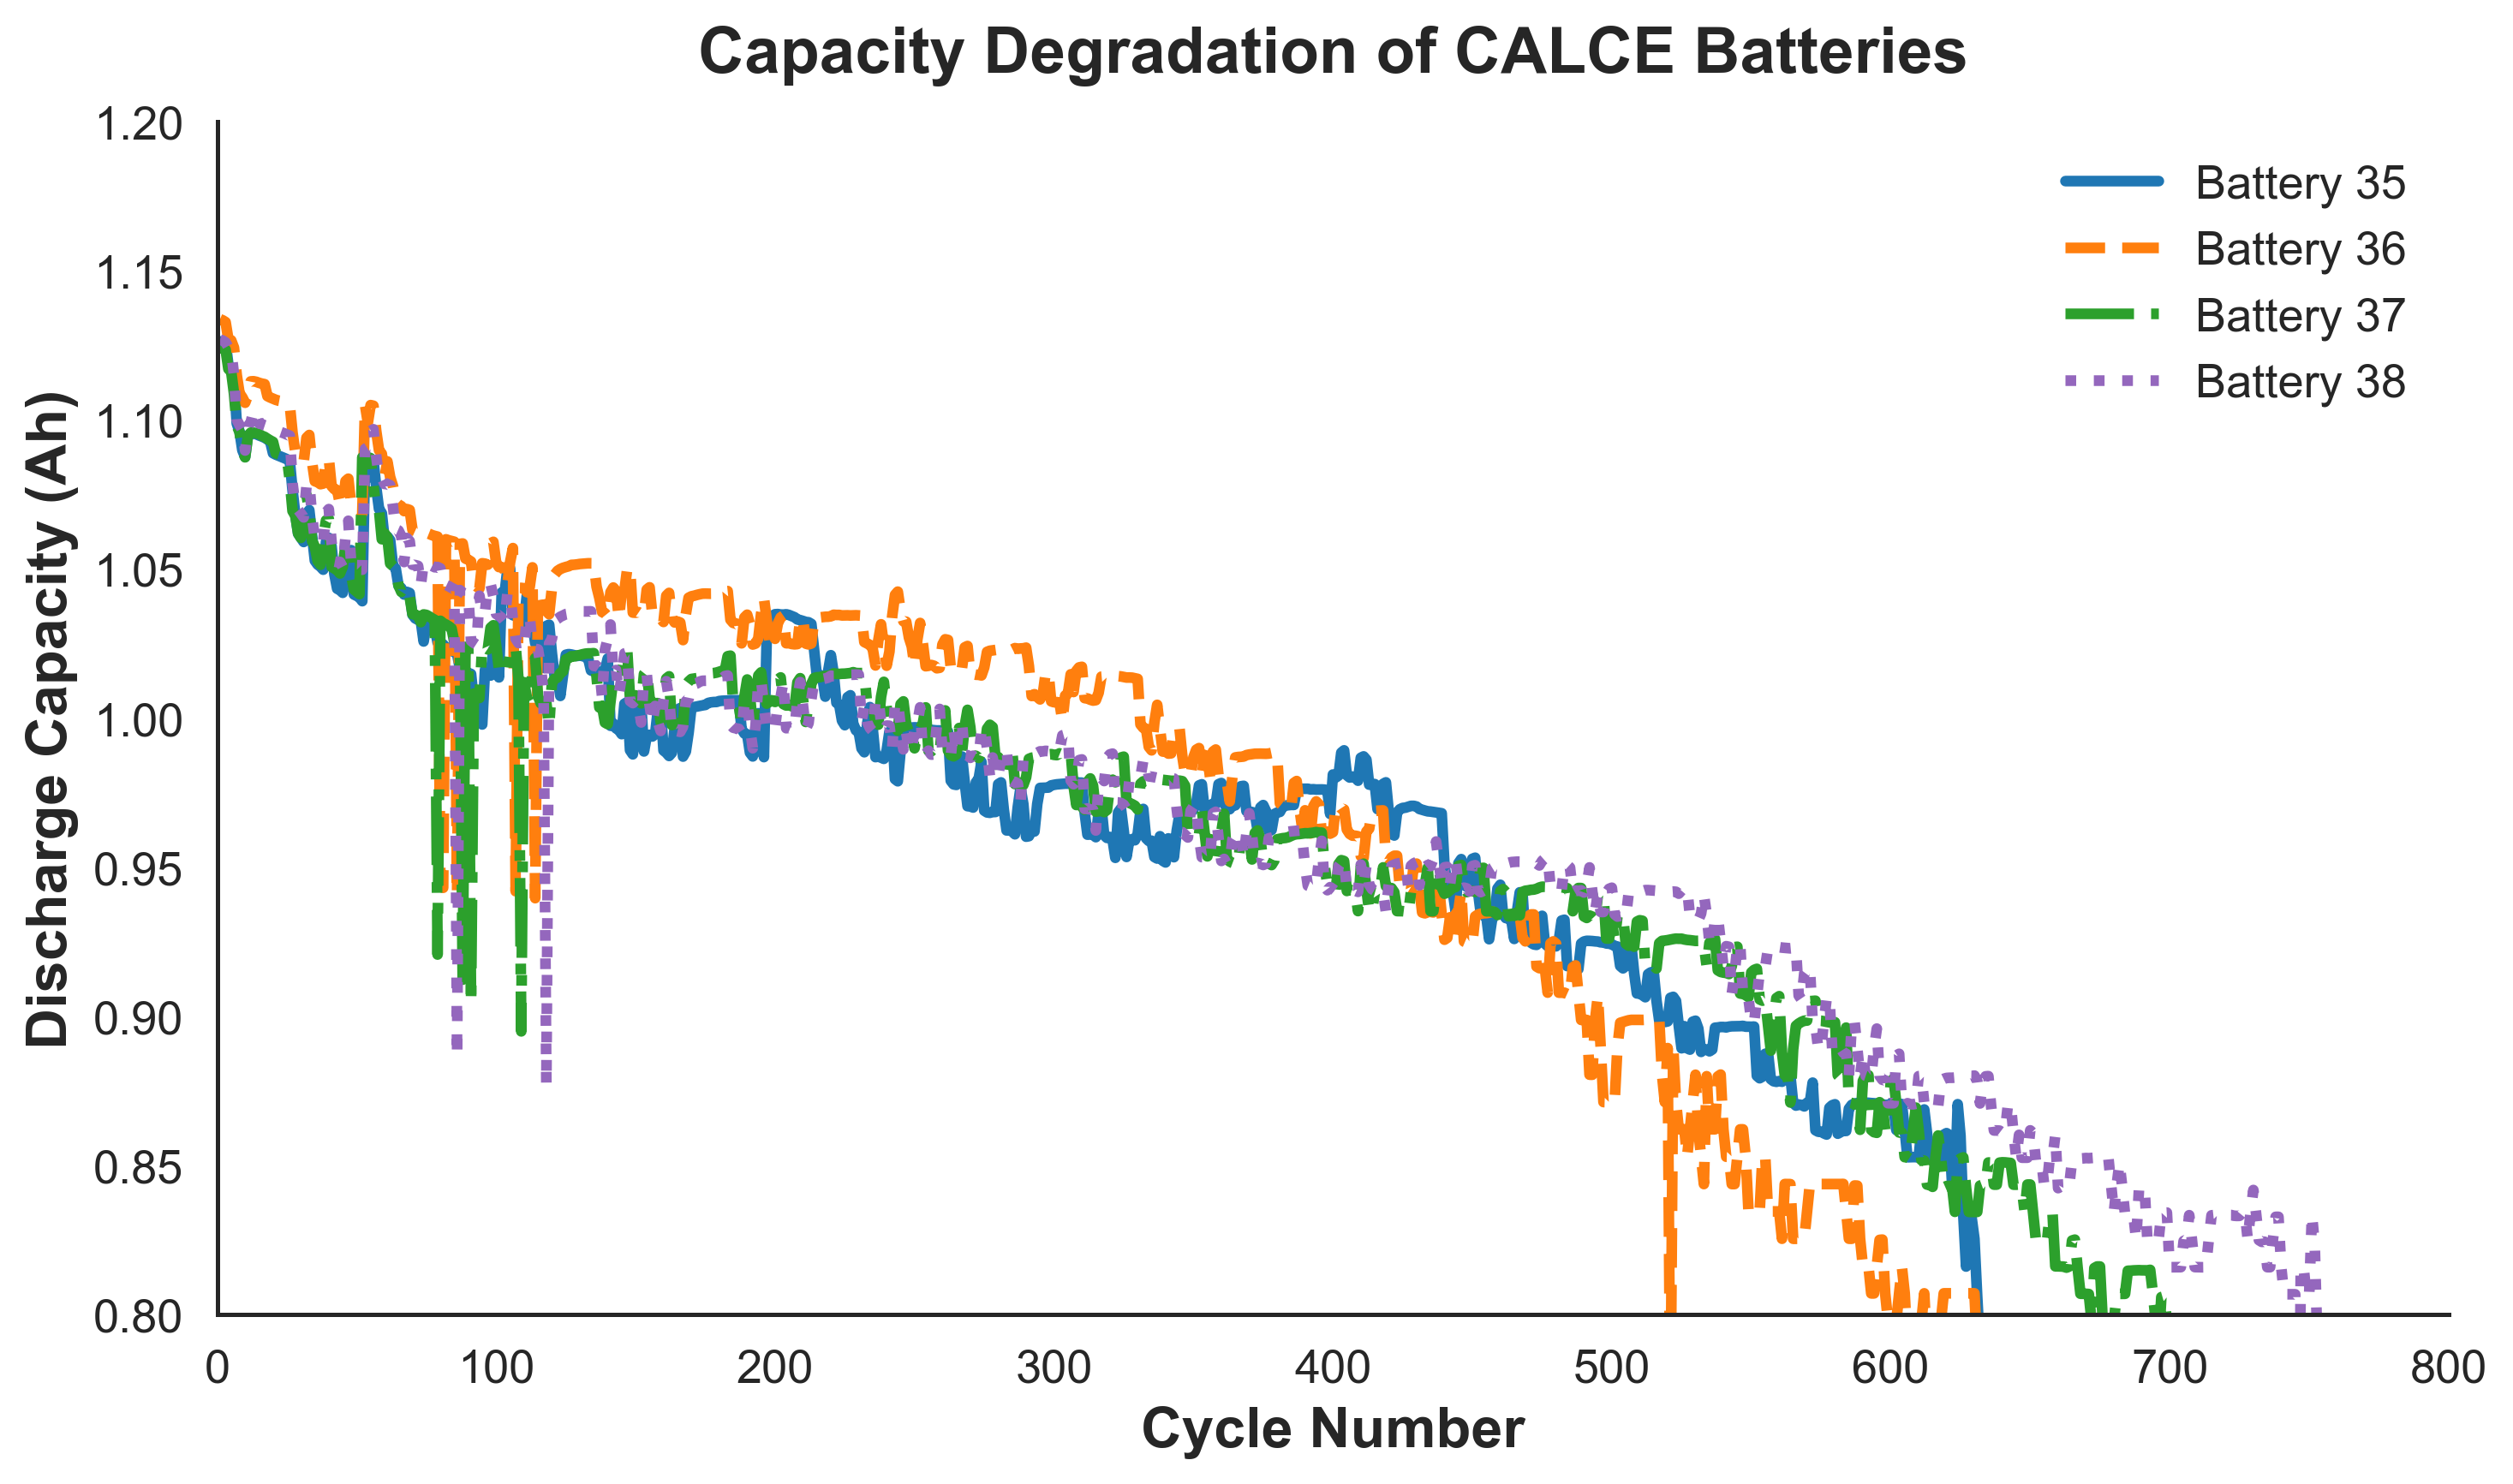

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置 SCI 图风格（不含网格）
sns.set_theme(style="white")
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'axes.linewidth': 1.2,
    'figure.figsize': [10, 6],
    'figure.dpi': 300,
    'axes.grid': False,  # 关闭默认网格
})

# 加载数据
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery = np.load('dataset/CALCE.npy', allow_pickle=True).item()

# 创建图表
fig, ax = plt.subplots()

# 柔和色 + 区分线型
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']
linestyles = ['-', '--', '-.', ':']

# 绘图（前800循环）
for i, name in enumerate(Battery_list):
    cycle_number = Battery[name]['cycle']
    capacity = Battery[name]['capacity']
    
    mask = cycle_number <= 800
    cycle_filtered = cycle_number[mask]
    capacity_filtered = capacity[mask]
    
    ax.plot(cycle_filtered,
            capacity_filtered,
            color=colors[i],
            linestyle=linestyles[i],
            linewidth=3.0,
            label=f'Battery {name[-2:]}')

# 坐标轴设置
ax.set_xlabel('Cycle Number', fontweight='bold')
ax.set_ylabel('Discharge Capacity (Ah)', fontweight='bold')
ax.set_xlim(0, 800)
ax.set_ylim(0.8, 1.2)

# 去除上右边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 去除网格
ax.grid(False)

# 图例设置
ax.legend(loc='upper right', frameon=False, fontsize=13)

# 标题
ax.set_title('Capacity Degradation of CALCE Batteries', pad=14, fontweight='bold')

# 紧凑布局
plt.tight_layout()

# 保存高清图
plt.savefig('D:/Jupyter/CALCE-main/dataset/CALCE_Battery_Degradation_Styled.png', dpi=600, bbox_inches='tight')

plt.show()


### 放电容量和内阻变化

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap

# 设置SCI风格（修改刻度方向）
plt.style.use('default')
rcParams.update({
    'font.family': 'Arial',
    'axes.linewidth': 1.2,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'xtick.direction': 'out',  # 修改为外侧刻度
    'ytick.direction': 'out',  # 修改为外侧刻度
    'xtick.major.size': 4,     # 刻度线长度
    'ytick.major.size': 4,     # 刻度线长度
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# 加载数据
Battery = np.load('dataset/CALCE.npy', allow_pickle=True).item()
bat = 'CS2_35'  # 仅使用CS2_35的数据

# 精确匹配参考图的渐变色
colors = [
    "#2b179b",  # 深紫蓝
    "#7e03a8",  # 蓝紫
    "#0d9b8c",  # 青色 
    "#f0f921"   # 亮黄
]
cmap = LinearSegmentedColormap.from_list("exact_match", colors)

# 提取数据
cycles = np.arange(len(Battery[bat]['CCCT']))
ccct = Battery[bat]['CCCT']
cvct = Battery[bat]['CVCT']
resistance = Battery[bat]['resistance']

def plot_subplot(data, ylabel, filename):
    plt.figure(figsize=(6, 4), dpi=300)
    sc = plt.scatter(cycles, data, c=cycles, cmap=cmap, 
                    norm=plt.Normalize(0, len(cycles)),
                    s=40, edgecolor='none')
    
    # 手动设置刻度朝外（确保兼容性）
    ax = plt.gca()
    ax.tick_params(axis='both', direction='out', which='major', length=4)
    
    plt.ylabel(ylabel)
    plt.xlabel('Cycle number')
    plt.grid(True)
    
    # 颜色条
    cbar = plt.colorbar(sc)
    cbar.set_label('Cycle Number', fontweight='bold')
    cbar.ax.tick_params(direction='out')  # 颜色条刻度也朝外
    
    # 边框控制
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(f'D:/Jupyter/CALCE-main/dataset/{filename}', bbox_inches='tight', dpi=300)
    plt.close()

# 绘制三张图
plot_subplot(ccct, 'CCCT (s)', 'CS2_35_CCCT.png')
plot_subplot(cvct, 'CVCT (s)', 'CS2_35_CVCT.png')
plot_subplot(resistance, 'Resistance (Ω)', 'CS2_35_Resistance.png')

print("三张图已保存（刻度朝外）：")
print("1. CS2_35_CCCT.png")
print("2. CS2_35_CVCT.png") 
print("3. CS2_35_Resistance.png")

三张图已保存（刻度朝外）：
1. CS2_35_CCCT.png
2. CS2_35_CVCT.png
3. CS2_35_Resistance.png


### 各项指标 v.s. 充放电周期

In [5]:
pip install SciencePlots

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np

# 加载文件
data = np.load('dataset/output/drop-outlter.npy', allow_pickle=True)

# 显示数据类型
print("实际内容类型：", type(data.item()))

# 解包后打印内容
content = data.item()
print("解包后的内容：")
print(content)



实际内容类型： <class 'dict'>
解包后的内容：
{'CS2_35':      cycle  capacity                                       voltage_norm  \
0      1.0  1.126385  [0.0005503302780047778, 0.0005552017537577963,...   
1      2.0  1.126160  [0.0005494545720018835, 0.0005544489422633509,...   
2      3.0  1.125966  [0.0005489411383965476, 0.0005540363980797899,...   
3      4.0  1.118508  [0.0005293812766753362, 0.0005377883901715064,...   
4      5.0  1.117210  [0.000527182297809413, 0.0005355095271827526, ...   
..     ...       ...                                                ...   
877  878.0  0.339218  [0.0031057937676833873, 0.0031226862891381036,...   
878  879.0  0.330025  [0.00329257197709622, 0.0033105878526556525, 0...   
879  880.0  0.330027  [0.0034833449428891407, 0.0035028033636412413,...   
880  881.0  0.320860  [0.003542799019793438, 0.0035622905154293824, ...   
881  882.0  0.320863  [0.003607917829329576, 0.0036280547611304372, ...   

                                          current_norm  \

Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_0.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_1.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_2.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_3.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_4.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_5.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_6.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_7.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_8.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_9.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_10.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_11.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_12.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_13.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_14.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_15.png
Sa

KeyboardInterrupt: 

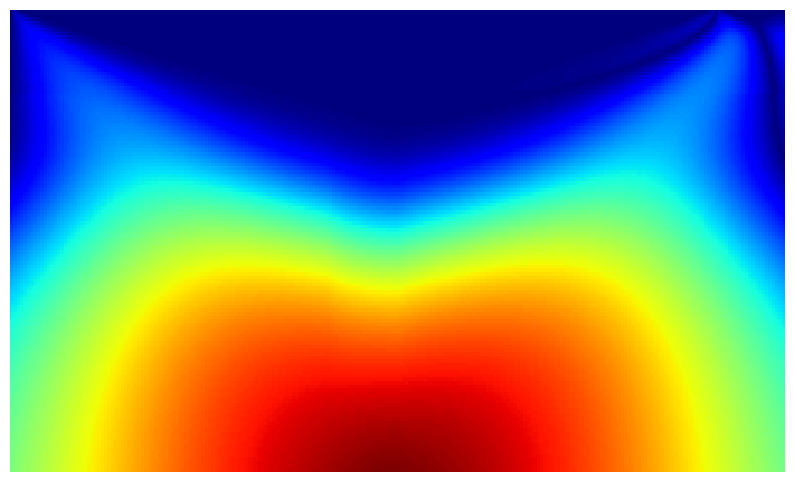

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import os

# 设置存储路径到 dataset 文件夹
save_dir = "dataset/CWTimg/CS2-355-current_norm"
os.makedirs(save_dir, exist_ok=True)  # 确保 dataset 文件夹存在

# 加载数据
Battery = np.load('dataset/output/drop-outlter.npy', allow_pickle=True).item()

# 选择电池数据
battery_name = 'CS2_35'
df = Battery[battery_name]

# 选择小波变换的尺度
scales = np.arange(1, 128)  # 1到128的尺度

# 遍历所有循环
for cycle in range(len(df)):  
    # 获取 voltage 信号
    voltage_signal = np.array(df['current_norm'][cycle])

    # 进行 CWT 变换
    coefficients = scipy.signal.cwt(voltage_signal, scipy.signal.ricker, scales)

    # 绘制 CWT 频谱图
    plt.figure(figsize=(10, 6))
    plt.imshow(np.abs(coefficients), aspect='auto',
               extent=[0, len(voltage_signal), scales[-1], scales[0]], cmap='jet')
    plt.axis('off')  # 关闭坐标轴
    # 保存图像到 dataset 文件夹
    save_path = os.path.join(save_dir, f"{battery_name}_cycle_{cycle}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()  # 关闭图像，避免内存占用

    print(f"Saved: {save_path}")

print("CWT transformation completed and images saved in dataset folder!")

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import os

# 设置存储路径到 dataset 文件夹
save_dir = "dataset/CWTimg/CS2-355-current_norm"
os.makedirs(save_dir, exist_ok=True)

# 加载数据
Battery = np.load('dataset/output/drop-outlter.npy', allow_pickle=True).item()

# 选择电池数据
battery_name = 'CS2_35'
df = Battery[battery_name]

# 设置小波尺度
scales = np.arange(1, 128)

# 遍历所有循环
for cycle in range(len(df)):  
    # 获取 current_norm 信号
    voltage_signal = np.array(df['current_norm'][cycle])

    # 进行连续小波变换
    coefficients = scipy.signal.cwt(voltage_signal, scipy.signal.ricker, scales)

    # 绘制热力图
    plt.figure(figsize=(10, 6))
    plt.imshow(np.abs(coefficients), aspect='auto',
               extent=[0, len(voltage_signal), scales[-1], scales[0]],
               cmap='jet', vmin=0.000, vmax=0.0050)  # <-- 手动设置热力值上下限
    plt.axis('off')

    # 保存图像
    save_path = os.path.join(save_dir, f"{battery_name}_cycle_{cycle}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

    print(f"Saved: {save_path}")

print("CWT transformation completed and images saved in dataset folder!")

Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_0.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_1.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_2.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_3.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_4.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_5.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_6.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_7.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_8.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_9.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_10.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_11.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_12.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_13.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_14.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_15.png
Sa

Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_130.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_131.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_132.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_133.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_134.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_135.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_136.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_137.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_138.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_139.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_140.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_141.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_142.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_143.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_144.png
Saved: dataset/CWTimg/CS2-355-current_no

Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_259.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_260.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_261.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_262.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_263.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_264.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_265.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_266.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_267.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_268.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_269.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_270.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_271.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_272.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_273.png
Saved: dataset/CWTimg/CS2-355-current_no

Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_388.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_389.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_390.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_391.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_392.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_393.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_394.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_395.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_396.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_397.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_398.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_399.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_400.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_401.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_402.png
Saved: dataset/CWTimg/CS2-355-current_no

Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_517.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_518.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_519.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_520.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_521.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_522.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_523.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_524.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_525.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_526.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_527.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_528.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_529.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_530.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_531.png
Saved: dataset/CWTimg/CS2-355-current_no

Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_646.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_647.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_648.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_649.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_650.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_651.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_652.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_653.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_654.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_655.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_656.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_657.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_658.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_659.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_660.png
Saved: dataset/CWTimg/CS2-355-current_no

Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_775.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_776.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_777.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_778.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_779.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_780.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_781.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_782.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_783.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_784.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_785.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_786.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_787.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_788.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_789.png
Saved: dataset/CWTimg/CS2-355-current_no

Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_0_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_1_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_2_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_3_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_4_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_5_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_6_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_7_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_8_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_9_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_10_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_11_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_12_with_colorbar.png
Saved: da

Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_107_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_108_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_109_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_110_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_111_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_112_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_113_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_114_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_115_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_116_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_117_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_118_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_119_with

Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_213_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_214_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_215_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_216_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_217_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_218_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_219_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_220_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_221_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_222_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_223_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_224_with_colorbar.png
Saved: dataset/CWTimg/CS2-355-current_norm\CS2_35_cycle_225_with

KeyboardInterrupt: 

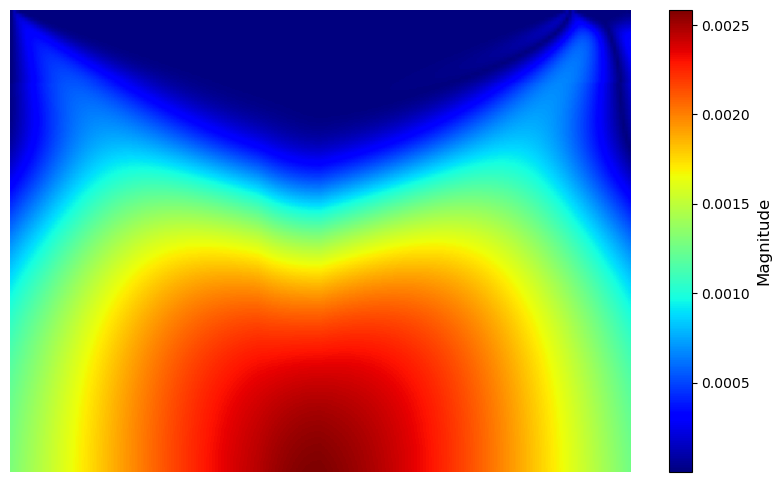

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import os

# 设置存储路径
save_dir = "dataset/CWTimg/CS2-355-current_norm"
os.makedirs(save_dir, exist_ok=True)

# 加载数据
Battery = np.load('dataset/output/drop-outlter.npy', allow_pickle=True).item()
battery_name = 'CS2_35'
df = Battery[battery_name]

# 小波尺度
scales = np.arange(1, 128)

# 遍历每个循环
for cycle in range(len(df)):
    voltage_signal = np.array(df['current_norm'][cycle])
    coefficients = scipy.signal.cwt(voltage_signal, scipy.signal.ricker, scales)

    # 绘图
    plt.figure(figsize=(10, 6))
    im = plt.imshow(np.abs(coefficients), aspect='auto',
                    extent=[0, len(voltage_signal), scales[-1], scales[0]], cmap='jet')
    
    # 添加颜色条（热力图 colorbar）
    cbar = plt.colorbar(im)
    cbar.set_label('Magnitude', fontsize=12)  # 可选：设置颜色条标签

    plt.axis('off')  # 是否显示坐标轴，可以注释掉这行看看效果

    # 保存
    save_path = os.path.join(save_dir, f"{battery_name}_cycle_{cycle}_with_colorbar.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1, facecolor='white')
    plt.close()

    print(f"Saved: {save_path}")

print("CWT heatmap with colorbar saved!")


In [18]:
import numpy as np

# Load the dataset
Battery2 = np.load('dataset/Battery1-voltage-rise-time.npy', allow_pickle=True)
Battery2 = Battery2.item()

# Print the keys in the dataset (Battery2)
print("Keys in Battery2:", Battery2.keys())

# Print the details of the data for a specific battery (for example 'CS2_35')
battery_name = 'CS2_35'
if battery_name in Battery2:
    print(f"Data for {battery_name}:")
    print(Battery2[battery_name])  # This will show the full data for 'CS2_35'
else:
    print(f"Battery {battery_name} not found in the dataset.")

Keys in Battery2: dict_keys(['CS2_35'])
Data for CS2_35:
     cycle  capacity       SoH         CCCT         CVCT  ICC_peak  \
0        1  1.138451  0.822988  6735.323593  2312.138082  3.662195   
1        1  1.128570  0.825173  6613.059052  2251.498033  3.674543   
2        1  1.128307  0.815966  6612.402800  2231.967052  3.668000   
3        1  1.127932  0.815976  6608.560673  2228.216959  3.670565   
4        2  1.122193  0.825196  6604.732222  2247.561061  3.683624   
..     ...       ...       ...          ...          ...       ...   
885     29  0.351841  0.128348  1269.603382          NaN  3.558370   
886     30  0.354121  0.137514  1542.270890          NaN  3.563226   
887     32  0.358746  0.146691  1228.090695  3091.945466  3.657741   
888     33  0.358711  0.137521  1214.120083  3044.823534  3.559125   
889     34  0.355252  0.137518  1244.057246  3012.670286  3.652641   

     charge_voltage_3p5_to_3p8_time  
0                         50.077408  
1                         

In [23]:
Battery_list = ['CS2_35'] 
Battery = np.load('dataset/Battery1-voltage-rise-time.npy', allow_pickle=True)
Battery = Battery.item() #new

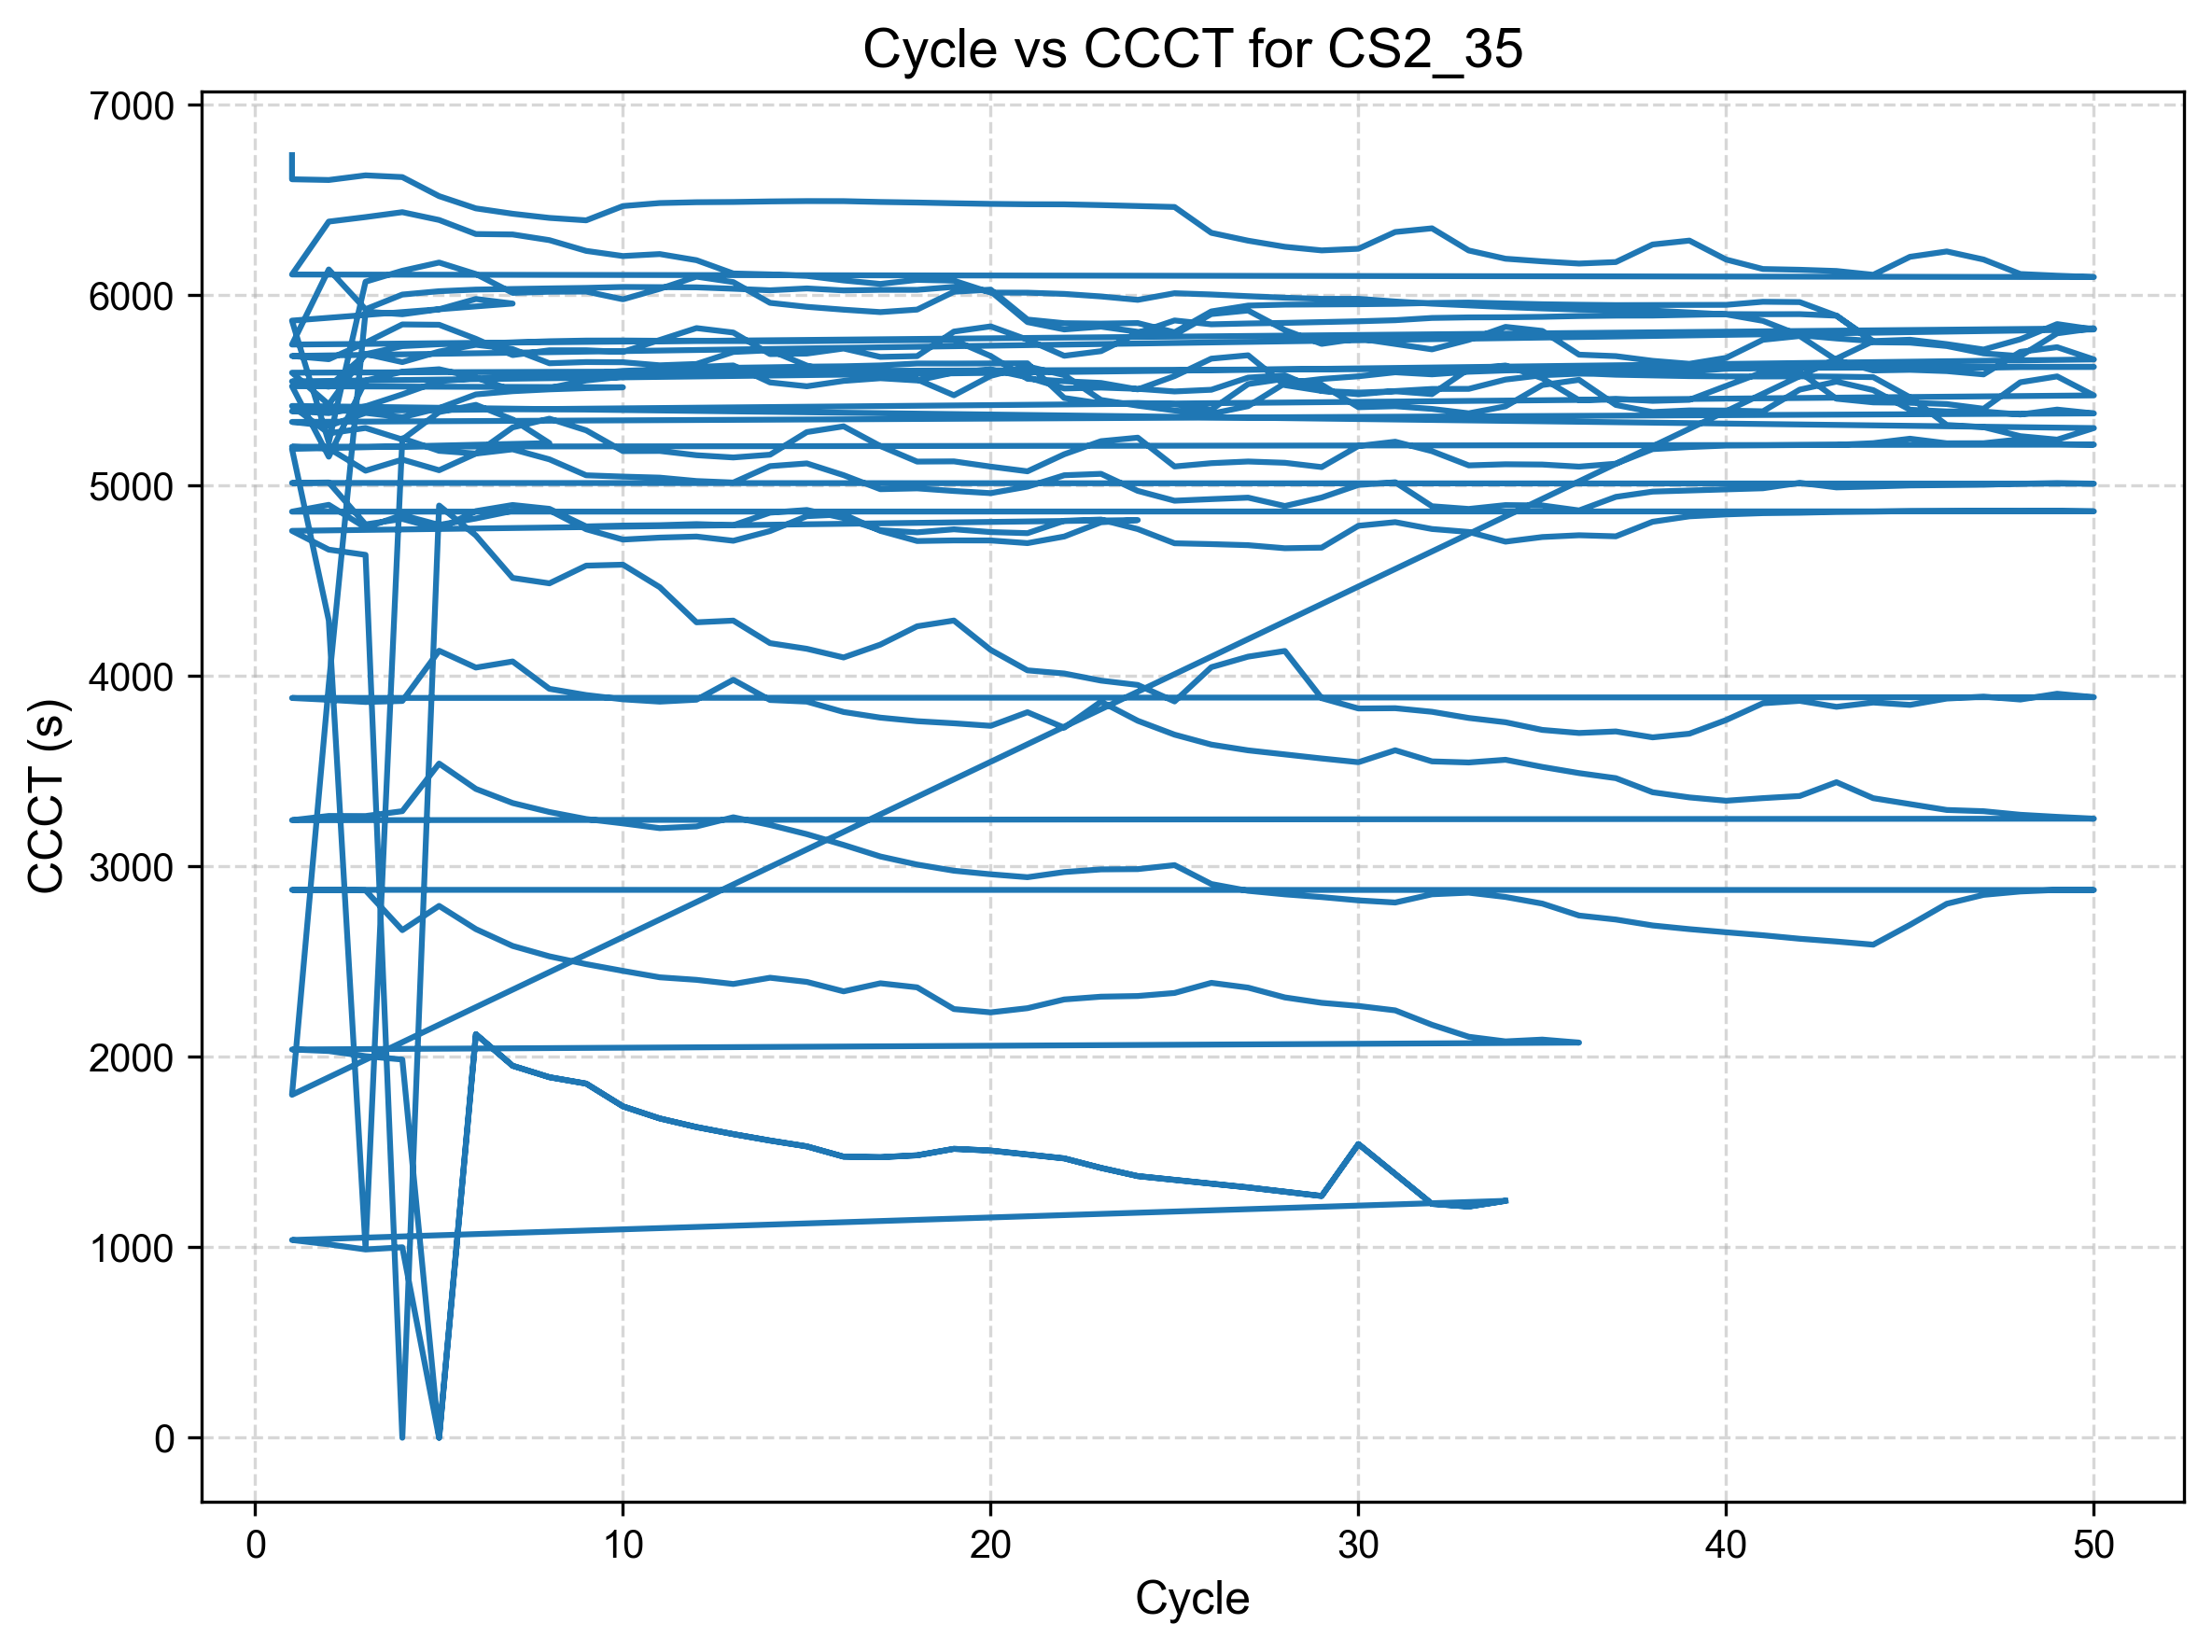

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 载入数据
Battery = np.load('dataset/Battery1-voltage-rise-time.npy', allow_pickle=True).item()

# 提取电池数据（例如 CS2_35）
df = Battery['CS2_35']  # 这是一个 pandas DataFrame

# 去除 CCCT 列中的 NaN 值
df_clean = df.dropna(subset=['CCCT'])

# 画图
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(df_clean['cycle'], df_clean['CCCT'], color='#1f77b4', linewidth=1.5)

# 标签和标题
plt.xlabel('Cycle', fontsize=12, fontname='Arial')
plt.ylabel('CCCT (s)', fontsize=12, fontname='Arial')
plt.title('Cycle vs CCCT for CS2_35', fontsize=14, fontname='Arial')
plt.grid(True, linestyle='--', alpha=0.5)

# 坐标轴美化
plt.tick_params(labelsize=10)
plt.tight_layout()

# 保存图像
#plt.savefig('cycle_vs_CCCT_CS2_35.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

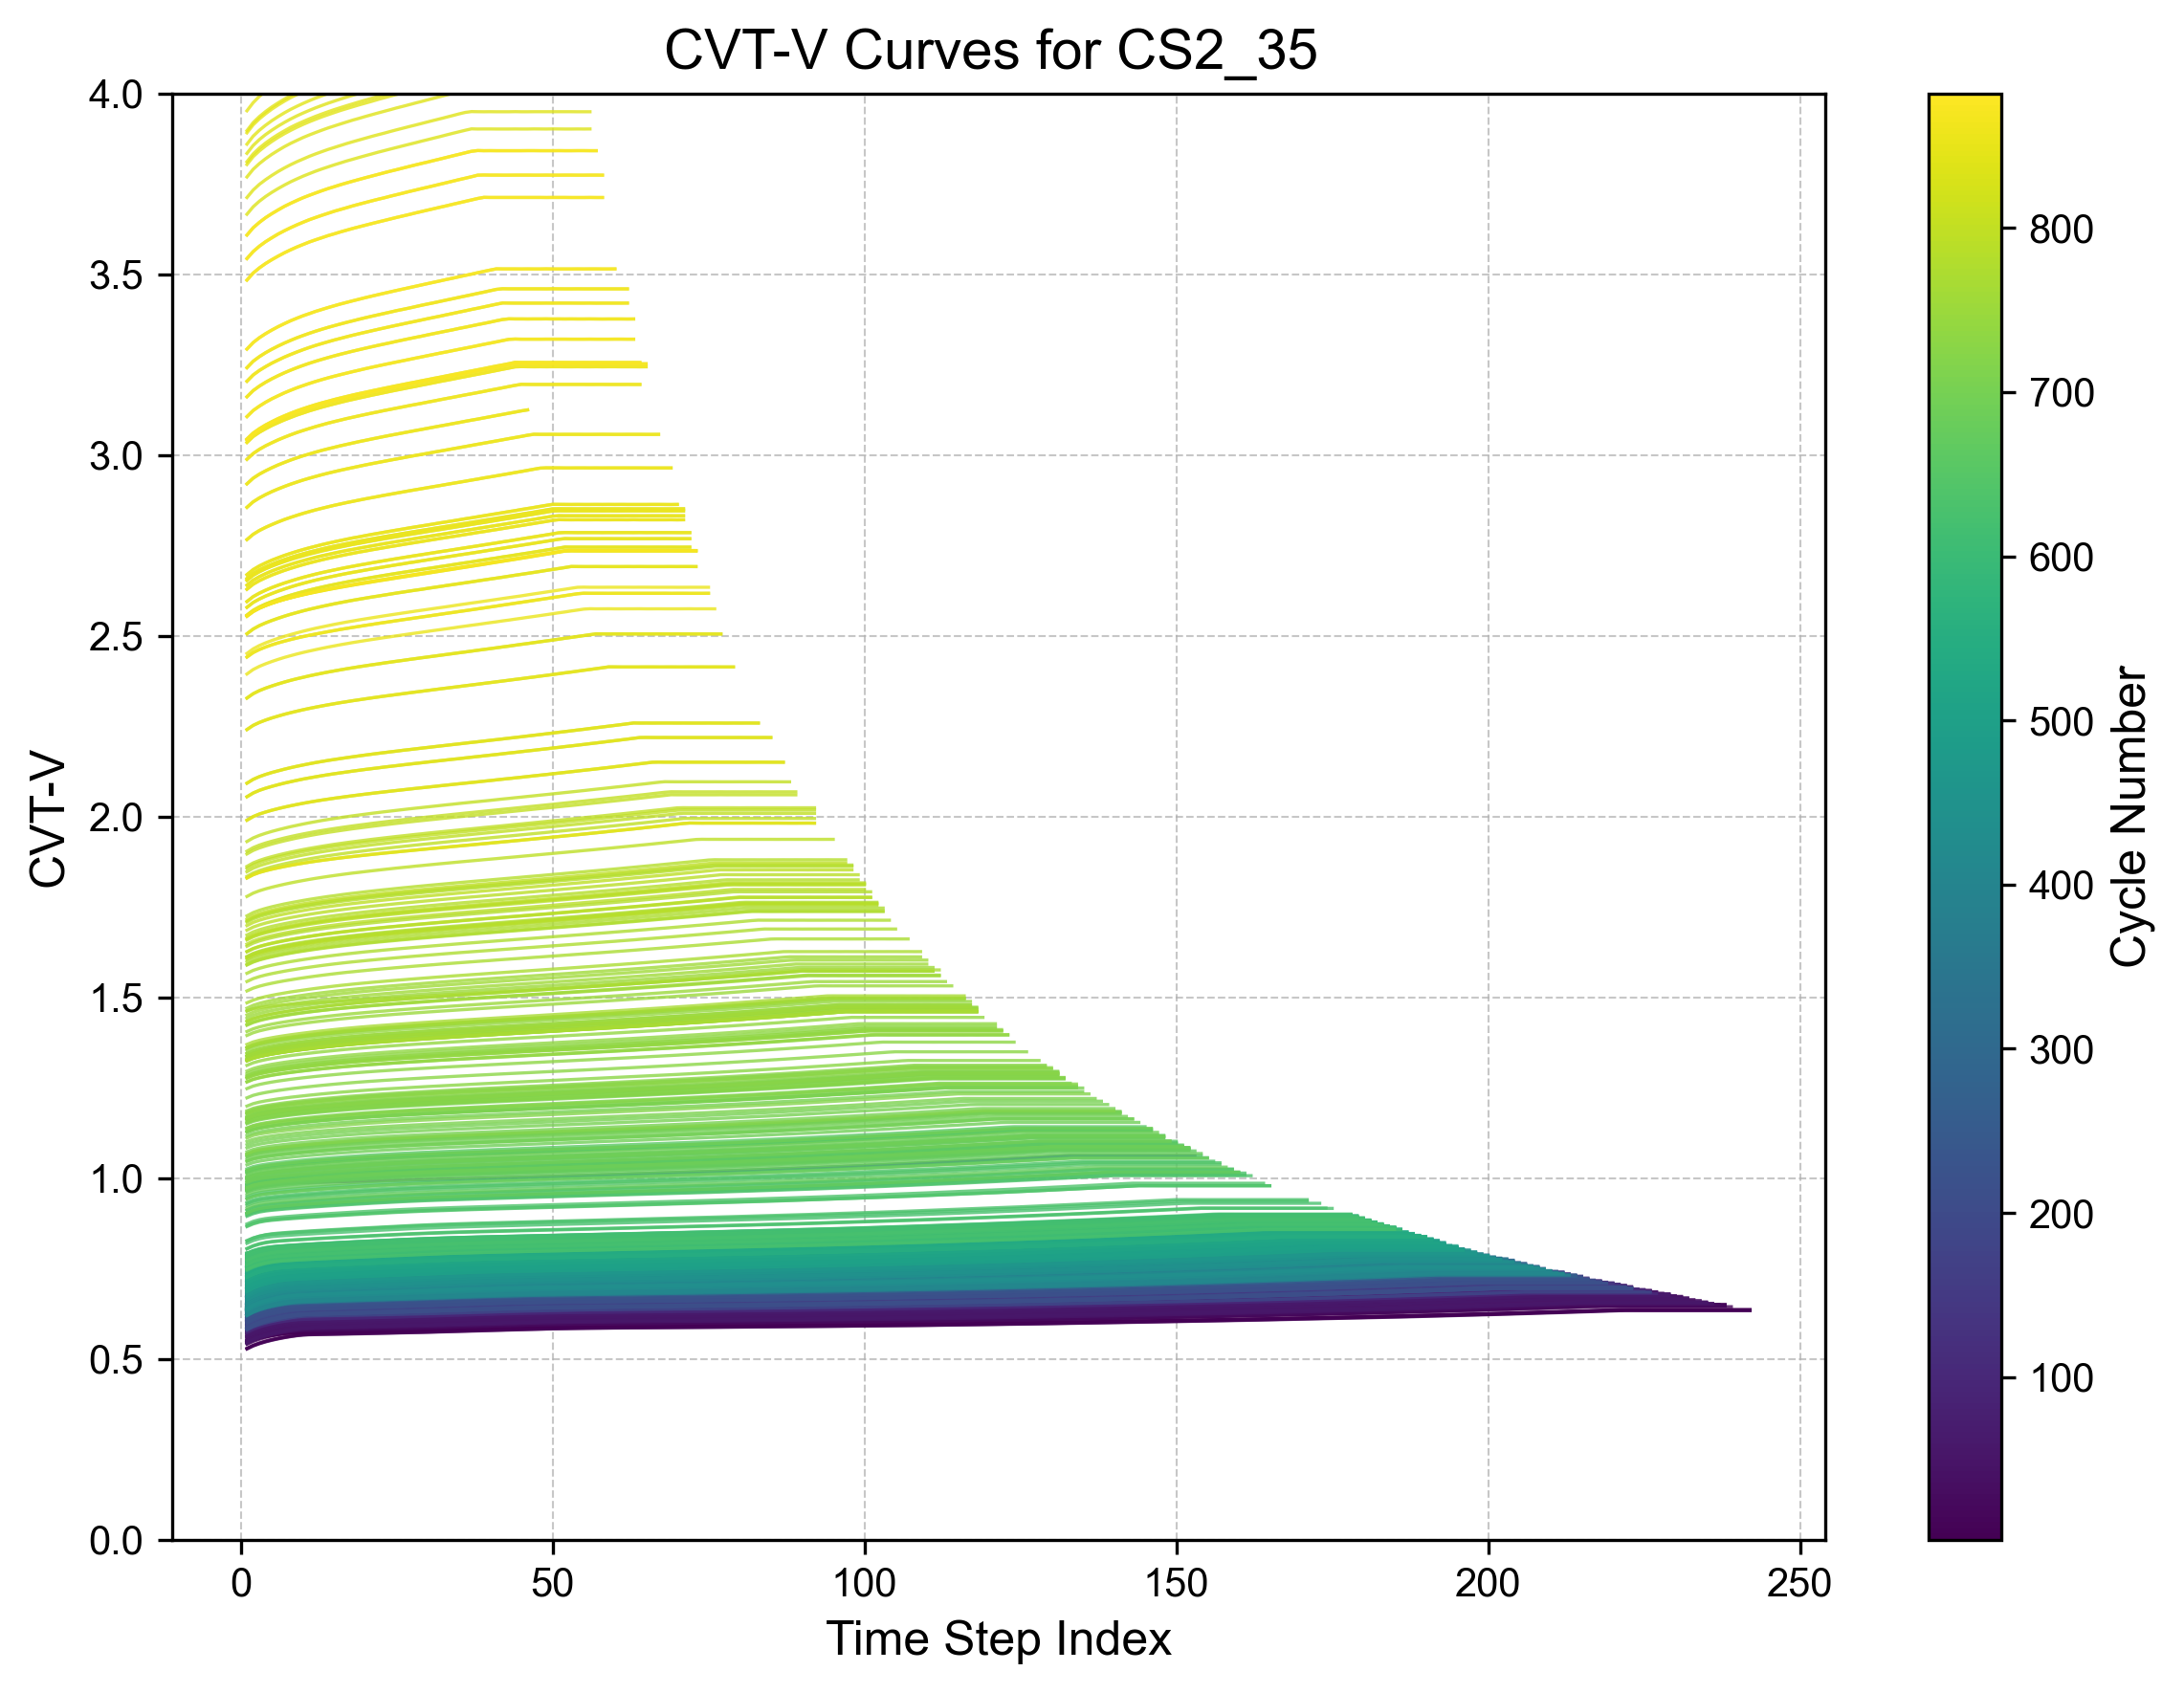

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# 加载数据
Battery2 = np.load('dataset/output/drop-outlter.npy', allow_pickle=True).item()
data_35 = Battery2['CS2_35']
num_cycles = len(data_35)

# 配色方案
cmap = cm.get_cmap('viridis', num_cycles)

# 图像风格
plt.figure(figsize=(8, 6), dpi=300)
plt.rcParams['font.family'] = 'Arial'

# 绘图
for idx, row in data_35.iterrows():
    voltage_list = row['voltage_norm']
    if isinstance(voltage_list, list) and len(voltage_list) > 0:
        voltage_scaled = [v * 1000 for v in voltage_list]
        color = cmap(idx / num_cycles)
        plt.plot(range(1, len(voltage_scaled) + 1), voltage_scaled,
                 color=color, linewidth=0.8, alpha=0.8)

# 设置颜色条
norm = mcolors.Normalize(vmin=data_35['cycle'].min(), vmax=data_35['cycle'].max())
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm)
cbar.set_label('Cycle Number', fontsize=12)

# 坐标轴标签和范围
plt.xlabel('Time Step Index', fontsize=12)
plt.ylabel('CVT-V', fontsize=12)
plt.title('CVT-V Curves for CS2_35 ', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# ✅ 显式设置 y 轴范围和刻度
plt.ylim(0, 4)
plt.yticks(np.arange(0, 4.5, 0.5))

plt.tight_layout()
plt.savefig('voltage_CS2_35_scaled_fixed.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


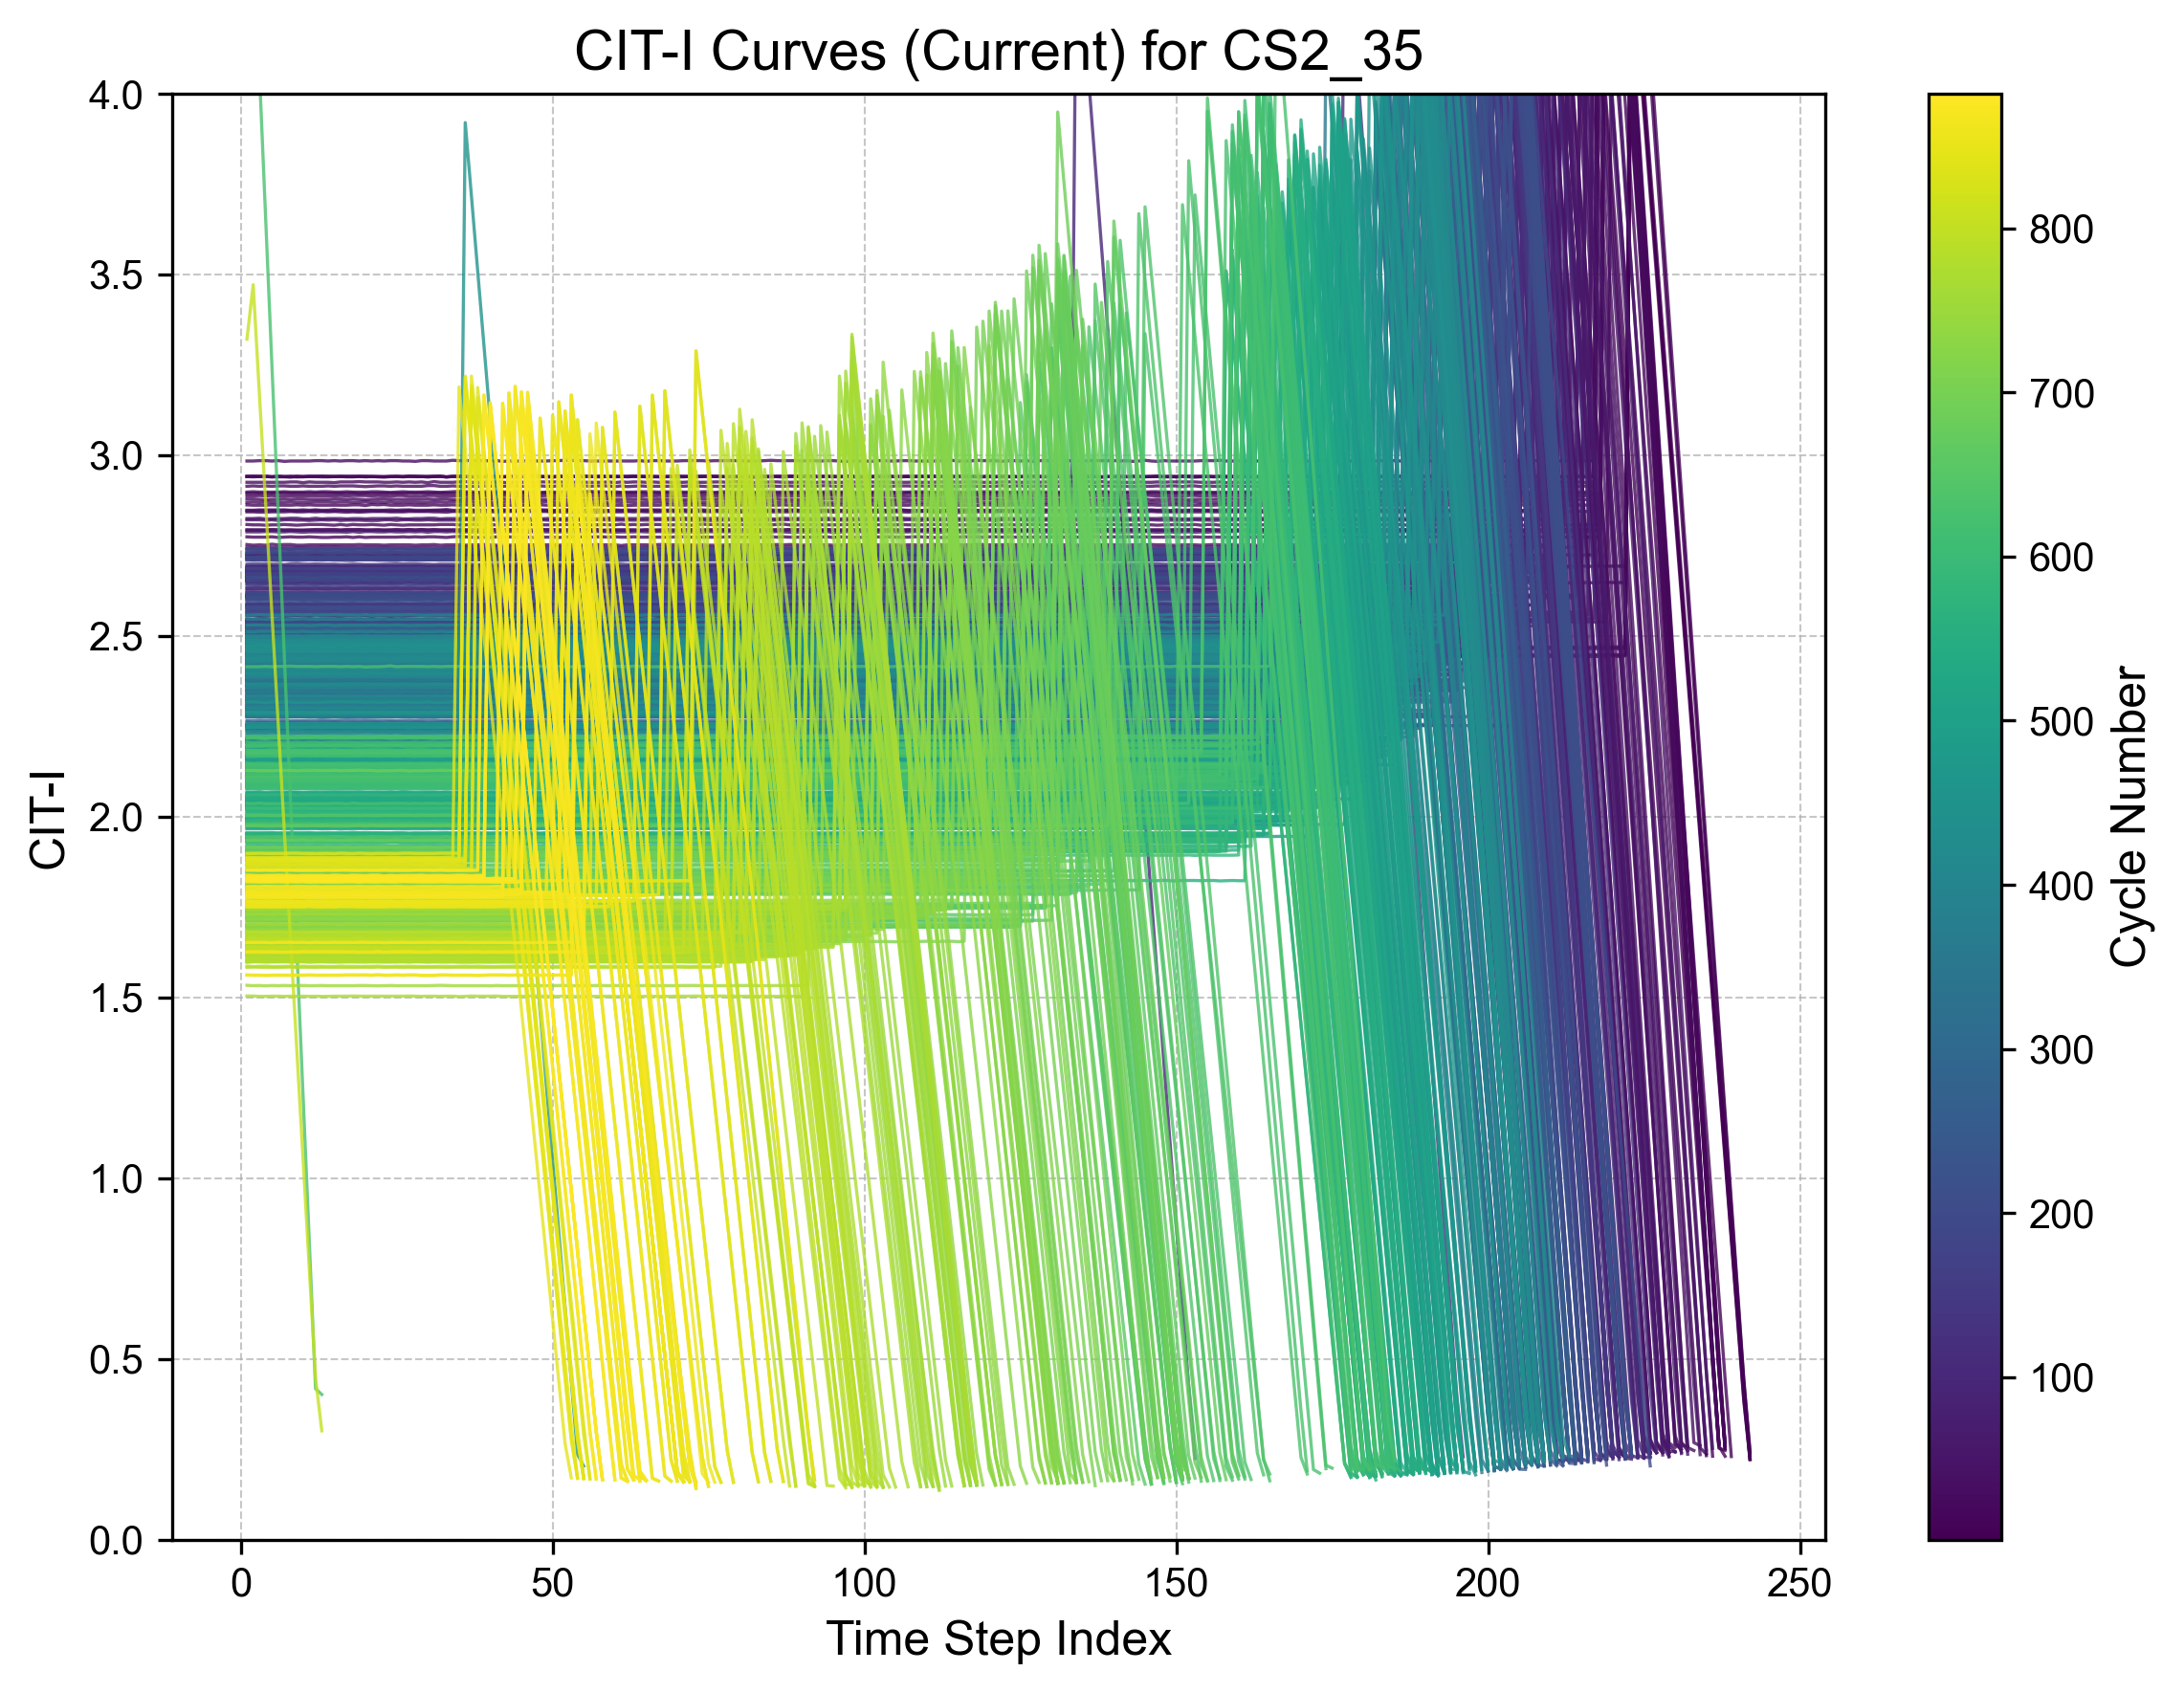

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# 加载数据
Battery2 = np.load('dataset/output/drop-outlter.npy', allow_pickle=True).item()
data_35 = Battery2['CS2_35']
num_cycles = len(data_35)

# 配色方案
cmap = cm.get_cmap('viridis', num_cycles)

# 图像风格
plt.figure(figsize=(8, 6), dpi=300)
plt.rcParams['font.family'] = 'Arial'

# 绘图
for idx, row in data_35.iterrows():
    current_list = row['current_norm']
    if isinstance(current_list, list) and len(current_list) > 0:
        current_scaled = [i * 10000 for i in current_list]  # 放大 1000 倍
        color = cmap(idx / num_cycles)
        plt.plot(range(1, len(current_scaled) + 1), current_scaled,
                 color=color, linewidth=0.8, alpha=0.8)

# 设置颜色条
norm = mcolors.Normalize(vmin=data_35['cycle'].min(), vmax=data_35['cycle'].max())
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm)
cbar.set_label('Cycle Number', fontsize=12)

# 坐标轴标签和范围
plt.xlabel('Time Step Index', fontsize=12)
plt.ylabel('CIT-I', fontsize=12)  # 可按需更改为 'Current Norm (×1000)' 等
plt.title('CIT-I Curves (Current) for CS2_35', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# 可选：y轴范围根据实际调整
plt.ylim(0, 4)
plt.yticks(np.arange(0, 4.5, 0.5))

plt.tight_layout()
plt.savefig('current_CS2_35_scaled_fixed.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

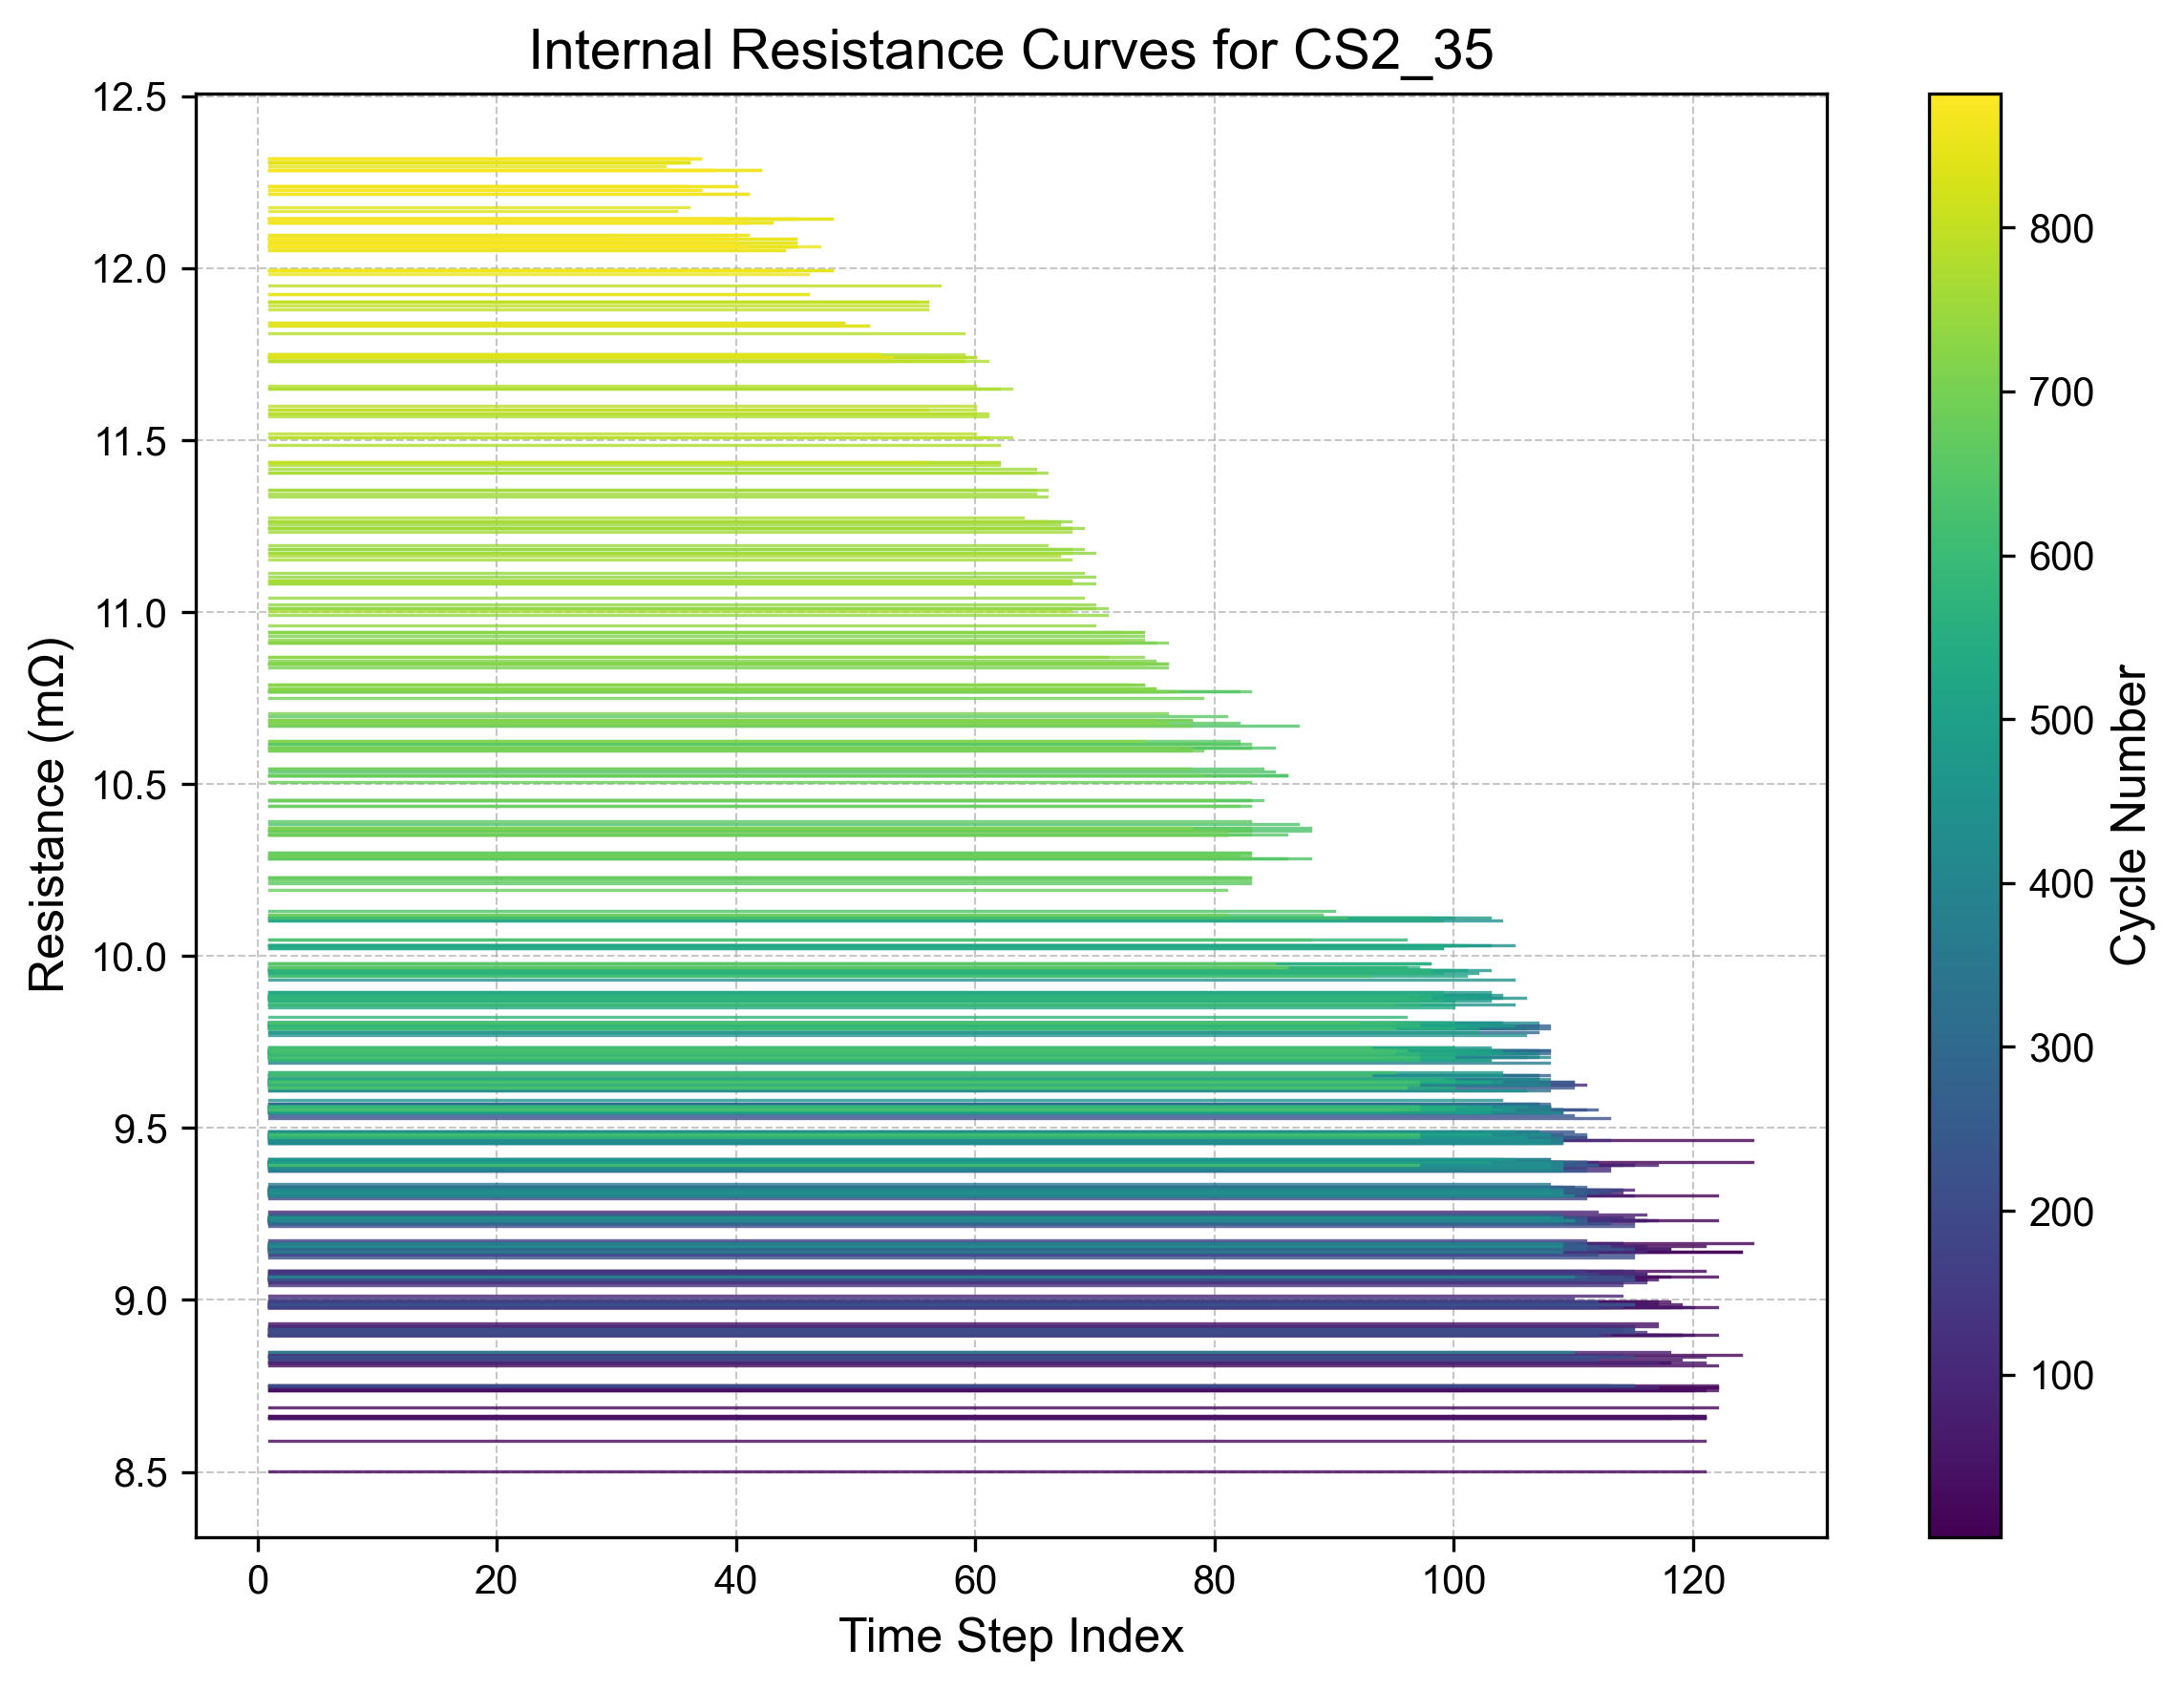

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# 加载数据
Battery2 = np.load('dataset/output/drop-outlter.npy', allow_pickle=True).item()
data_35 = Battery2['CS2_35']
num_cycles = len(data_35)

# 配色方案
cmap = cm.get_cmap('viridis', num_cycles)

# 图像风格
plt.figure(figsize=(8, 6), dpi=300)
plt.rcParams['font.family'] = 'Arial'

# 绘图
for idx, row in data_35.iterrows():
    resistance_list = row['resistance']
    if isinstance(resistance_list, list) and len(resistance_list) > 0:
        resistance_scaled = [r * 100 for r in resistance_list]  # 放大1000倍
        color = cmap(idx / num_cycles)
        plt.plot(range(1, len(resistance_scaled) + 1), resistance_scaled,
                 color=color, linewidth=0.8, alpha=0.8)

# 设置颜色条
norm = mcolors.Normalize(vmin=data_35['cycle'].min(), vmax=data_35['cycle'].max())
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm)
cbar.set_label('Cycle Number', fontsize=12)

# 坐标轴标签和范围
plt.xlabel('Time Step Index', fontsize=12)
plt.ylabel('Resistance (mΩ)', fontsize=12)
plt.title('Internal Resistance Curves for CS2_35', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# 自动范围或手动设置 y 轴范围（如需）
# plt.ylim(0, 150)  # 例如阻抗最大到 0.15Ω（150mΩ），可根据实际调整
# plt.yticks(np.arange(0, 160, 20))

plt.tight_layout()
plt.savefig('resistance_CS2_35_scaled_fixed.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
